# Section 1: Data Loading & Cleaning
We load the nodes and edges datasets for the darknet network, inspect their structure, handle missing or inconsistent values, and prepare them for network construction.


In [1]:
# Imports 
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) # this adds the src folder to path so we can import utils
from src import utils
import importlib
importlib.reload(utils); # reload utils to get latest changes

In [2]:
nodes, edges = utils.load_data() # load data using our function

### 1.1 Inspection
Let's inspect the data in order to undersatnd the structure


In [3]:
display(nodes.shape)
display(edges.shape)

(7178, 2)

(25104, 4)

In [4]:
nodes.head()


,Id,Label
0,visitorfi5kl7q7i,NaN
1,uisspxbl7ipc5bet,NaN
2,directoryvi6plzm,NaN
3,telnetg42y5crrb7,NaN
4,gl75awtvsmp2ofe6,NaN


In [5]:
edges.head()

,Source,Target,Type,Weight
0,visitorfi5kl7q7i,uisspxbl7ipc5bet,Directed,1
1,visitorfi5kl7q7i,xidp5a5k3rlxr5r3,Directed,1
2,visitorfi5kl7q7i,7uvijlsswycvih2p,Directed,1
3,visitorfi5kl7q7i,4oy7nsv57l3ragqz,Directed,1
4,visitorfi5kl7q7i,prometh5th5t5rfd,Directed,1


### 1.2 Any missing values?
Let us check for missing values 

In [6]:
nodes.isna().sum()

Id          0
Label    7178
dtype: int64

In [7]:
edges.isna().sum()

Source    0
Target    0
Type      0
Weight    0
dtype: int64

### 1.3 Dropping unnecessary/redundant colums
As we can see, we have no missing data, but the `Label` column is just null values. So:
- From nodes: `Label` should be dropped

In [8]:
if 'Label' in nodes.columns:
    nodes.drop(columns=['Label'], inplace=True)  # Drop Label column if it exists
nodes.head()

,Id
0,visitorfi5kl7q7i
1,uisspxbl7ipc5bet
2,directoryvi6plzm
3,telnetg42y5crrb7
4,gl75awtvsmp2ofe6


In [9]:
display(edges["Type"].value_counts())
display(edges["Weight"].value_counts())

Type
Directed    25104
Name: count, dtype: int64

Weight
1       8013
5       5930
2       5685
3       3286
4        846
        ... 
1084       1
1210       1
4980       1
1529       1
7742       1
Name: count, Length: 205, dtype: int64

From this we can see that for edges all values of `Type` is `'Directed'` so the column is redundant. If there were more types, of course it would be kept. So:
- From edges: `Type` should be dropped.

In [10]:
if "Type" in edges.columns:
    edges.drop(columns=["Type"], inplace=True)  # Drop Type column if it exists
edges.head()

,Source,Target,Weight
0,visitorfi5kl7q7i,uisspxbl7ipc5bet,1
1,visitorfi5kl7q7i,xidp5a5k3rlxr5r3,1
2,visitorfi5kl7q7i,7uvijlsswycvih2p,1
3,visitorfi5kl7q7i,4oy7nsv57l3ragqz,1
4,visitorfi5kl7q7i,prometh5th5t5rfd,1


### 1.4 Any duplicates?
Let's also check if there are any duplicate rows in nodes or edges

In [11]:
print("Duplicate nodes:", nodes.duplicated().sum())
print("Duplicate edges:", edges.duplicated().sum())

Duplicate nodes: 0
Duplicate edges: 0


This looks fine.
### 1.5 Transforming IDs for ease of readibality and interpretability 
To make it easier to reference nodes and edges we are gonna transform the IDs of nodes form their links into sequantial integers

In [12]:
nodes = utils.transform_node_ids(nodes)
edges = utils.transform_edge_ids(edges, nodes)
display(nodes.head())
display(edges.head())

,Id,Name
0,0,visitorfi5kl7q7i
1,1,uisspxbl7ipc5bet
2,2,directoryvi6plzm
3,3,telnetg42y5crrb7
4,4,gl75awtvsmp2ofe6


,Source,Target,Weight
0,0,1,1
1,0,7,1
2,0,15,1
3,0,20,1
4,0,24,1


### Section 1 Summary

Data was loaded, cleaned (dropped unnecessary columns, checked for missing values and duplicates), and IDs were transformed to sequential integers for easier interpretation. The dataset is now ready for network analysis.


# Section 2: Basic Network Statistics

In this section, we consrtuct the network from the cleaned nodes and edges, computee important metrics, and explore structural properties to understand the network itself


In [13]:
# Construct the graph as a a directed graph 
G = nx.from_pandas_edgelist(edges, source='Source', target='Target', create_using=nx.DiGraph) 

### 2.1 Basic info

In [14]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 7178
Number of edges: 25104


In [15]:
print(f"Network density: {nx.density(G)}")

Network density: 0.00048730012862285344


We have a very sparse graph!

### 2.2 Degree statistics

Let's compute the in/out/total degree distributions and statistics

In [16]:
 # Compute degree distributions
in_degrees = np.array([d for _, d in G.in_degree()])
out_degrees = np.array([d for _, d in G.out_degree()])
total_degrees = np.array([d for _, d in G.degree()])
# little statistics
print("In-Degree: min =", in_degrees.min(), ", max =", in_degrees.max(), ", mean =", in_degrees.mean())
print("Out-Degree: min =", out_degrees.min(), ", max =", out_degrees.max(), ", mean =", out_degrees.mean())
print("Total-Degree: min =", total_degrees.min(), ", max =", total_degrees.max(), ", mean =", total_degrees.mean(), ", median =", np.median(total_degrees))

In-Degree: min = 1 , max = 209 , mean = 3.497353023126219
Out-Degree: min = 0 , max = 5582 , mean = 3.497353023126219
Total-Degree: min = 1 , max = 5583 , mean = 6.994706046252438 , median = 3.0


From the max of Out-Degree, we can see that there is a domain from which we can reach more than 70% of the domains!

In [17]:
pd.Series(in_degrees).value_counts().sort_index()


1      1647
2      1793
3      1672
4       980
5       320
6       201
7       150
8        76
9        49
10       30
11       39
12       24
13       22
14       19
15       12
16        5
17       12
18       14
19       10
20        8
21        2
22        3
23        7
24        6
25        7
26        3
27        3
28        6
29        4
30        1
31        6
32        4
33        4
34        4
35        2
36        3
37        2
38        1
39        5
40        3
41        4
42        2
45        1
47        1
51        1
54        1
56        2
57        2
58        1
60        1
61        1
88        1
209       1
Name: count, dtype: int64

Very large portion, 70%, of the nodes have a low in-degree count(<3)

In [18]:
pd.Series(out_degrees).value_counts().sort_index()

0       6242
1        636
2         85
3         34
4         25
        ... 
848        1
2758       1
2769       1
4367       1
5582       1
Name: count, Length: 79, dtype: int64

87% of sites do not link to any others, they are endpoints

In [19]:
out_degrees_with_nodes = pd.Series(dict(G.out_degree()))
out_degrees_with_nodes.sort_values(ascending=False).head(10)


2      5582
0      4367
22     2769
6      2758
5       848
12      498
243     478
73      309
84      294
138     222
dtype: int64

The nodes [2,0,22,6] are the main hubs

Let's plot these using histograms to get the distributions.

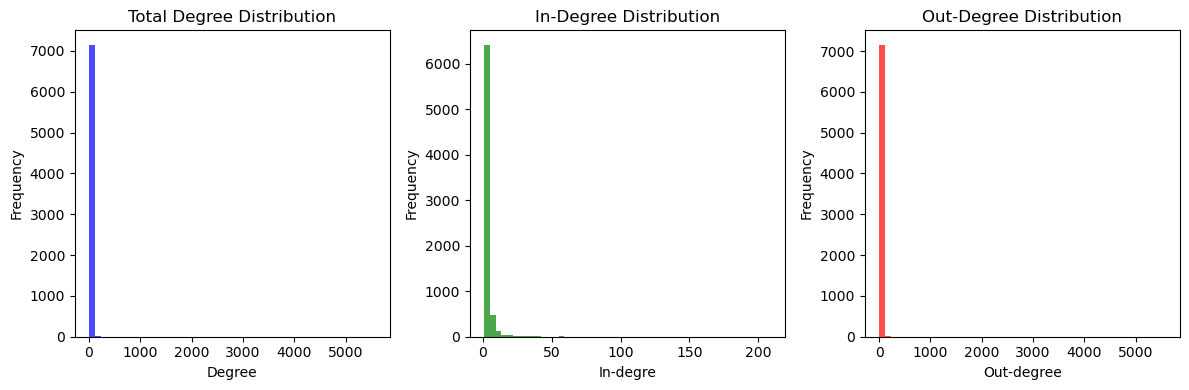

In [20]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(total_degrees, bins=50, color='blue', alpha=0.7)
plt.title("Total Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")

plt.subplot(1, 3, 2)
plt.hist(in_degrees, bins=50, color='green', alpha=0.7)
plt.title("In-Degree Distribution")
plt.xlabel("In-degre")
plt.ylabel("Frequency")

plt.subplot(1, 3, 3)
plt.hist(out_degrees, bins=50, color='red', alpha=0.7)
plt.title("Out-Degree Distribution")
plt.xlabel("Out-degree")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

Let's also visualize it using log-scale plots.

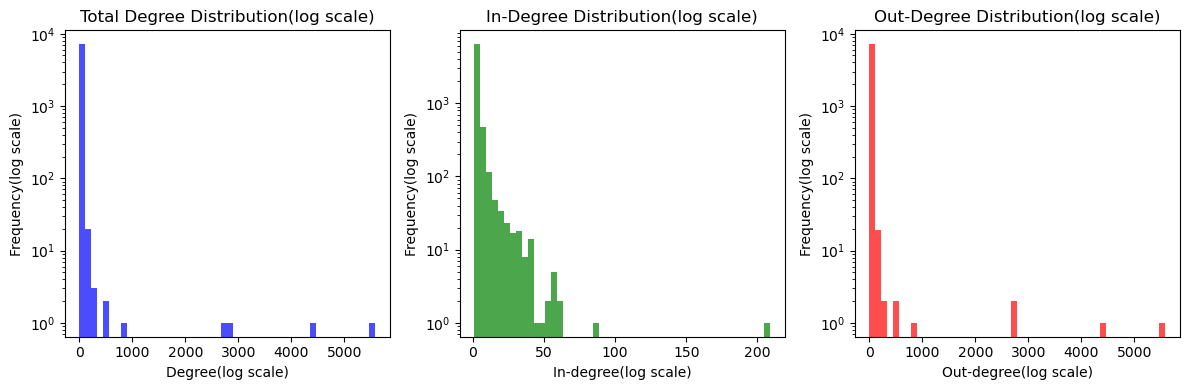

In [21]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(total_degrees, bins=50, color='blue', alpha=0.7, log=True)
plt.title("Total Degree Distribution(log scale)")
plt.xlabel("Degree(log scale)")
plt.ylabel("Frequency(log scale)")

plt.subplot(1, 3, 2)
plt.hist(in_degrees, bins=50, color='green', alpha=0.7, log=True)
plt.title("In-Degree Distribution(log scale)")
plt.xlabel("In-degree(log scale)")
plt.ylabel("Frequency(log scale)")

plt.subplot(1, 3, 3)
plt.hist(out_degrees, bins=50, color='red', alpha=0.7, log=True)
plt.title("Out-Degree Distribution(log scale)")
plt.xlabel("Out-degree(log scale)")
plt.ylabel("Frequency(log scale)")

plt.tight_layout()
plt.show()

### 2.3 Cumulative distribution and power-law

Now we can also plot the cumulative degree distribution for total degree on a log-log scale and then attempt to fit a power-law using `powerlaw.Fit`.

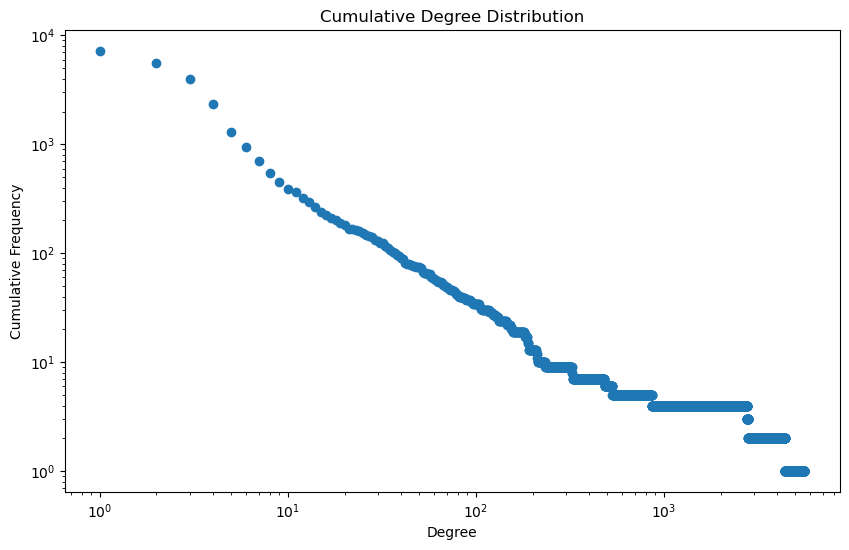

In [22]:
degree_counts = np.bincount(total_degrees)
cumulative_counts = np.cumsum(degree_counts[::-1])[::-1]
deg_vals = np.arange(len(cumulative_counts))
plt.figure(figsize=(10,6))
plt.loglog(deg_vals, cumulative_counts, marker='o', linestyle='none')
plt.title('Cumulative Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Cumulative Frequency')
plt.show()

Hmm, it does not look like a power-law distribution. Let's fit a power-law distribution to the degree data and see how well it fits.

In [23]:
import powerlaw
nonzero_degrees = total_degrees[total_degrees >= 1] # powerlaw package cannot handle zeros
fit = powerlaw.Fit(nonzero_degrees, discrete=True) # fit power law distribution

print(f"Estimated alpha = {fit.alpha:.3f}")
print(f"Estimated xmin  = {fit.xmin}")

R, p = fit.distribution_compare('power_law', 'lognormal') # compare power law to lognormal
print(f"Loglikelihood ratio R = {R:.3f}, p-value = {p:.3f}")
if R > 0 and p < 0.05:
    print("Power law.")
else:
    print("Not power law.")

    
    

Calculating best minimal value for power law fit
Estimated alpha = 2.058
Estimated xmin  = 9.0
Loglikelihood ratio R = -0.004, p-value = 0.920
Not power law.


No, it is definitely not a power law. Let's plot it nonetheless power-law compared to our data

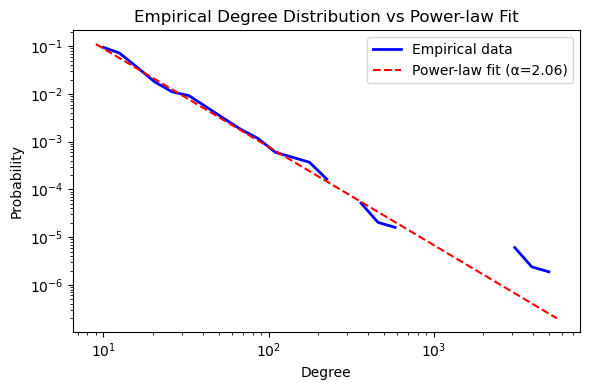

In [24]:
plt.figure(figsize=(6,4))
fit.plot_pdf(color='b', linewidth=2, label='Empirical data')
fit.power_law.plot_pdf(color='r', linestyle='--', label=f'Power-law fit (α={fit.alpha:.2f})')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Degree")
plt.ylabel("Probability")
plt.title("Empirical Degree Distribution vs Power-law Fit")
plt.legend()
plt.tight_layout()
plt.show()

The devations observed in this plot(gaps and deviations) is consistent with our statistical testing. There's also not enough orders of data to definitely check for a power law(gaps), but we can most likely deny a powerlaw.

### 2.4 Clustering

For clustering, we use the directed graph. It uses Fagiolo's(2007) definiton for clustering, as the undirected version of the graph would significantly overestimate.


In [25]:
global_clustering = nx.transitivity(G) # global cluserting
local_clustering = nx.clustering(G) # local clustering
avg_clustering = nx.average_clustering(G)   # average local clustering

local_clustering_values = np.array(list(local_clustering.values())) # lets  convert to numpy array for easy statistics



print(f"Global clustering: {global_clustering:.6f}")
print(f"Average clustering (undirected): {avg_clustering:.6f}")
print(f"Local clustering summary: min={local_clustering_values.min():.6f}, median={np.median(local_clustering_values):.6f}, max={local_clustering_values.max():.6f}")



Global clustering: 0.000964
Average clustering (undirected): 0.506139
Local clustering summary: min=0.000000, median=0.566667, max=1.000000


Low clustering shows that the graph is not very "cliquish", meaning that nodes' neighbors are not highly interconnected. This was expected as its a real-world sparse network

### 2.5 Assortattivity and reciprocity

In [26]:
recip = nx.reciprocity(G) # reciprocity, meaning the proportion of edges that go both ways
# degree assortativity for undirected degrees or for directed using in/out (here use total degree)
assort = nx.degree_assortativity_coefficient(G.to_undirected()) # assortativity, the correlation between the degrees of connected nodes
print(f"Reciprocity: {recip}")
print(f"Degree assortativity (undirected): {assort:.6f}")

Reciprocity: 0.017925430210325048
Degree assortativity (undirected): -0.442950


As we can see, most edges dont go both ways(low reciprocity), and the network is disassortative (high degree nodes tend to connect to low degree nodes)

### 2.6 Connected components, diameter and average shortest path
Diameter and average shortest path is computed on the largest strongly connected component(SCC)

In [27]:
sccs = list(nx.strongly_connected_components(G))
num_scc = len(sccs)
largest_scc = max(sccs, key=len)
size_largest_scc = len(largest_scc)

wccs = list(nx.weakly_connected_components(G))
num_wcc = len(wccs)
largest_wcc = max(wccs, key=len)
size_largest_wcc = len(largest_wcc)

print(f"Number of strongly connected components: {num_scc}")
print(f"Size of largest strongly connected component: {size_largest_scc}")
print(f"Number of weakly connected components: {num_wcc}")
print(f"Size of largest weakly connected component: {size_largest_wcc}")


Number of strongly connected components: 6820
Size of largest strongly connected component: 297
Number of weakly connected components: 1
Size of largest weakly connected component: 7178


In [28]:
sccs_sizes = pd.Series([len(scc) for scc in sccs])
display(sccs_sizes.value_counts().sort_index())
print(sccs_sizes.value_counts(normalize=True).sort_index())

1      6783
2        22
3         8
4         3
6         3
297       1
Name: count, dtype: int64

1      0.994575
2      0.003226
3      0.001173
4      0.000440
6      0.000440
297    0.000147
Name: proportion, dtype: float64


We can see that the the network is extremely fragmented and more than 99% of the nodes are not part of any cycles. But we have the big SCC which dominates the network in directed sense. The other nodes can be described as peripherial.
<p>Because the number of nodes is equal to the largest weakly connected component, the graph is weakly connected. It is not stronlgy connected though, but we got the largest strongly connected component as well, which has a size of 297 nodes

In [29]:
largest_scc = G.subgraph(largest_scc).copy()
asp = nx.average_shortest_path_length(largest_scc)
diam = nx.diameter(largest_scc)
print(f"Average shortest path length (largest SCC): {asp:.6f}")
print(f"Diameter (largest SCC): {diam}")

Average shortest path length (largest SCC): 3.966034
Diameter (largest SCC): 10


This means we can go from a domain to another one in the SCC with 4 moves by average, and the largest distance is 10 between 2 nodes. This SCC is most likely the core of our network, where the domains link to each other. We think that the core is made up of the forums/wikis/link dictionaries of the darknet.

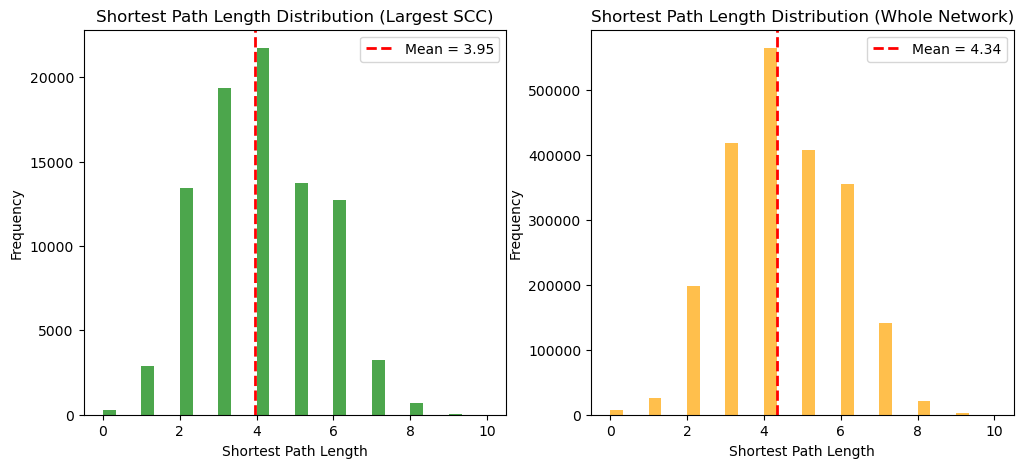

In [30]:
path_lengths = [d for u, v_dict in nx.shortest_path_length(largest_scc) for _, d in v_dict.items()]
mean_length = np.mean(path_lengths)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(path_lengths, bins=30, color='green', alpha=0.7)
plt.axvline(mean_length, color='red', linestyle='--', linewidth=2, label=f"Mean = {mean_length:.2f}")
plt.title("Shortest Path Length Distribution (Largest SCC)")
plt.xlabel("Shortest Path Length")
plt.ylabel("Frequency")
plt.legend()


all_lengths = []
for component in nx.weakly_connected_components(G):
    subgraph = G.subgraph(component)
    lengths = [d for u, v_dict in nx.shortest_path_length(subgraph) for _, d in v_dict.items()]
    all_lengths.extend(lengths)
    
mean_length = np.mean(all_lengths)
plt.subplot(1, 2, 2)
plt.hist(all_lengths, bins=30, color='orange', alpha=0.7)
plt.axvline(mean_length, color='red', linestyle='--', linewidth=2, label=f"Mean = {mean_length:.2f}")
plt.title("Shortest Path Length Distribution (Whole Network)")
plt.xlabel("Shortest Path Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()

We can also see a plot of the shortest path lengths of the largest SCC and the whole graph.

We can also try to visualize the largest SCC to using nx's built-in fuctions

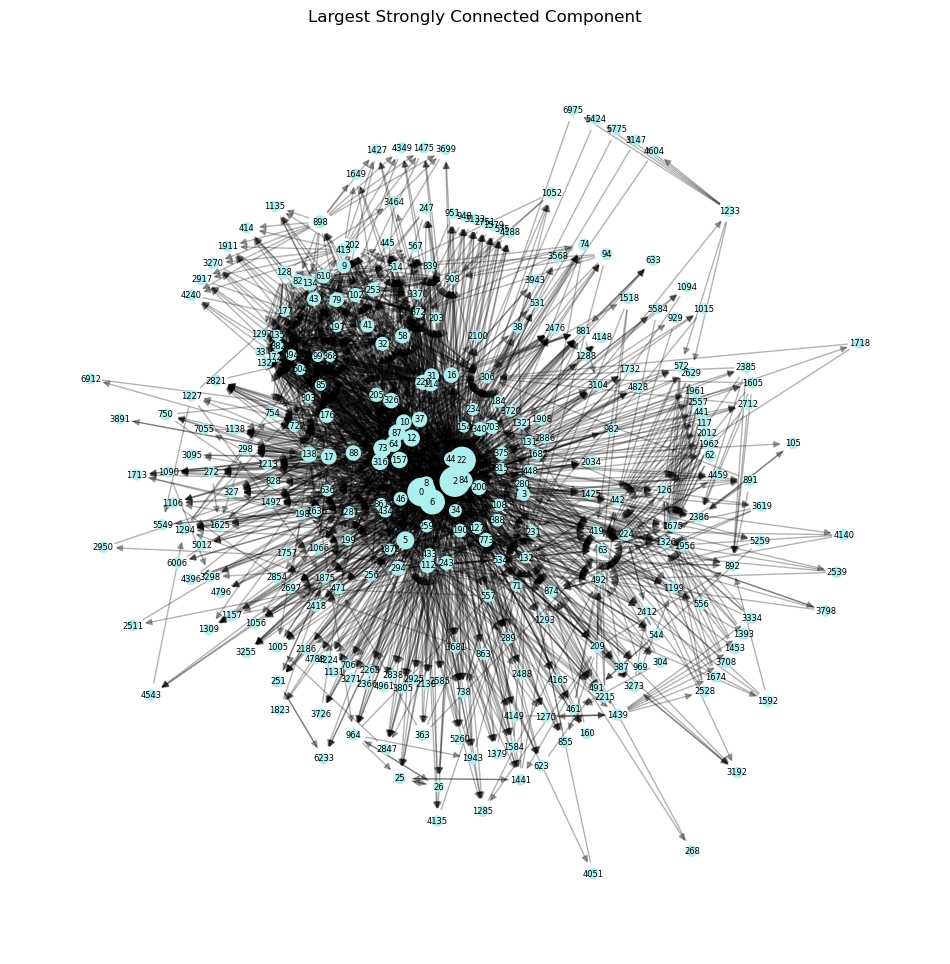

In [31]:
plt.figure(figsize=(12,12))

pos = nx.kamada_kawai_layout(largest_scc)  # layout for visualization. I tried spring_layout but this one spreads out the nodes better 

node_sizes = [50 + 1.5*largest_scc.out_degree(n) for n in largest_scc] # this makes the node size proportional to out-degree

nx.draw_networkx_nodes(largest_scc, pos, node_size=node_sizes, node_color="paleturquoise") # drawing the noddes
nx.draw_networkx_edges(largest_scc, pos, alpha=0.3, arrows=True) # drawing the edges with arrows cause its directed
nx.draw_networkx_labels(largest_scc, pos, font_size=6) # and adding the numbers as label

plt.title("Largest Strongly Connected Component")
plt.axis('off')
plt.show()


We are ignoring 6881 nodes, so this does not reflect the global network. We can see how it is on the largest weekly connected network if the graph was undirected just as a sidenote.

In [32]:
largest_wcc = (G.subgraph(largest_wcc).copy()).to_undirected()
asp_wcc = nx.average_shortest_path_length(largest_wcc)
diam_wcc = nx.diameter(largest_wcc)
print(f"Average shortest path length (largest WCC): {asp_wcc:.6f}")
print(f"Diameter (largest WCC): {diam_wcc}")

Average shortest path length (largest WCC): 2.370392
Diameter (largest WCC): 5


### 2.7 Edge weights summary

Edge weights represent the number of links between Source -> Target. It's worth noting that Source and Target are domains, not pages, so a domain can have multiple pages. Let's check their distribution


Edge weights: min=1, median=2.0, mean=144.59, max=2027613


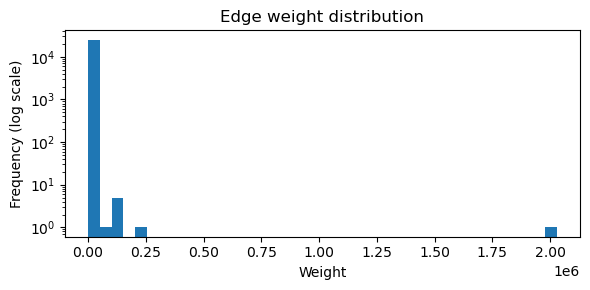

In [33]:
weights = edges['Weight'].values
print(f"Edge weights: min={weights.min()}, median={np.median(weights)}, mean={weights.mean():.2f}, max={weights.max()}")
# simple histogram
plt.figure(figsize=(6,3))
plt.hist(weights, bins=40)
plt.yscale('log')
plt.title("Edge weight distribution")
plt.xlabel("Weight")
plt.ylabel("Frequency (log scale)")
plt.tight_layout()
plt.show()

Hmm this very skewed, lets check the high values.

In [34]:
edges['Weight'].sort_values(ascending=False).head(20)

23251    2027613
23283     207099
23279     103549
23280     103549
23281     103549
23282     103549
23284     103548
23285      68666
24011      38360
24283      35262
24171      32052
24093      27694
24331      21542
24402      21272
24445      20890
24504      18234
24503      18234
23571      11640
24666      11640
24656      11549
Name: Weight, dtype: int64

Some hubs/forums dominate the weights. Large edge weights happen because there are  domains which contain thousands or even millions of hyperlinks pointing repeatedly to the same other domains. This may be because of mirrored sites, link directories, or automated linking. Let's look at the distribution without those.

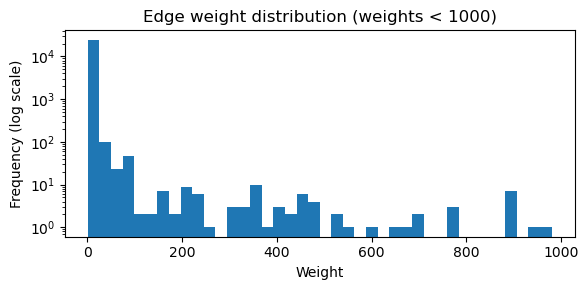

In [35]:
plt.figure(figsize=(6,3))
plt.hist(weights[weights < 1000], bins=40)
plt.yscale('log')
plt.title("Edge weight distribution (weights < 1000)")
plt.xlabel("Weight")
plt.ylabel("Frequency (log scale)")
plt.tight_layout()
plt.show()


We don't use the Graph as weighted, because the number of links does not change for example the shortest-path distance, and it doesn't make make a path shorter or longer neither. It could be used for degree counts, but we are interested in the overall structure of the network, so we chose to ignore this.

### Section 2 short summary

The network shows a heavy-tailed degree distribution but does not follow a true power law. It is very sparse,  directed, and has low density with several disconnected components. Clustering analysis indicates that most connections occur between and not within groups of nodes. We also discovered a core and periphery structure.



# Section 3: Node Centrality

Lets measure the most imporant and influential nodes in the network. As it is directed, we can consider both in and out-flows.



We have already checked out the degree distributions in 2.2, let's check the highest degree nodes now

In [36]:
in_degrees_dict = dict(G.in_degree())
out_degrees_dict = dict(G.out_degree())
total_degrees_dict = dict(G.degree())
top_10_in_degrees = sorted(in_degrees_dict.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_out_degrees = sorted(out_degrees_dict.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_total_degrees = sorted(total_degrees_dict.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 nodes by in-degree:")
for node, degree in top_10_in_degrees:
    print(f"Node {node}: In-Degree = {degree}")



Top 10 nodes by in-degree:
Node 502: In-Degree = 209
Node 652: In-Degree = 88
Node 1247: In-Degree = 61
Node 132: In-Degree = 60
Node 449: In-Degree = 58
Node 282: In-Degree = 57
Node 306: In-Degree = 57
Node 205: In-Degree = 56
Node 197: In-Degree = 56
Node 63: In-Degree = 54


In [37]:
print("\nTop 10 nodes by out-degree:")
for node, degree in top_10_out_degrees:
    print(f"Node {node}: Out-Degree = {degree}")


Top 10 nodes by out-degree:
Node 2: Out-Degree = 5582
Node 0: Out-Degree = 4367
Node 22: Out-Degree = 2769
Node 6: Out-Degree = 2758
Node 5: Out-Degree = 848
Node 12: Out-Degree = 498
Node 243: Out-Degree = 478
Node 73: Out-Degree = 309
Node 84: Out-Degree = 294
Node 138: Out-Degree = 222


In [38]:
print("\nTop 10 nodes by total degree:")
for node, degree in top_10_total_degrees:
    print(f"Node {node}: Total Degree = {degree}")


Top 10 nodes by total degree:
Node 2: Total Degree = 5583
Node 0: Total Degree = 4385
Node 22: Total Degree = 2810
Node 6: Total Degree = 2764
Node 5: Total Degree = 861
Node 12: Total Degree = 531
Node 243: Total Degree = 482
Node 84: Total Degree = 326
Node 73: Total Degree = 324
Node 138: Total Degree = 233


We can see some very central nodes 

### 3.2 Betweenness Centrality
This measures to what extent nodes are part of the shortest paths between other nodes.

In [39]:
betweenness = nx.betweenness_centrality(G)

print("Top 10 nodes by Betweenness Centrality:")
top_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]
for node, centrality in top_betweenness:
    print(f"Node: {node}, Betweenness Centrality: {centrality:.4f}")

Top 10 nodes by Betweenness Centrality:
Node: 0, Betweenness Centrality: 0.0186
Node: 12, Betweenness Centrality: 0.0155
Node: 22, Betweenness Centrality: 0.0148
Node: 84, Betweenness Centrality: 0.0105
Node: 205, Betweenness Centrality: 0.0070
Node: 442, Betweenness Centrality: 0.0069
Node: 154, Betweenness Centrality: 0.0061
Node: 32, Betweenness Centrality: 0.0048
Node: 197, Betweenness Centrality: 0.0045
Node: 63, Betweenness Centrality: 0.0033


These are the bridges between parts of the darknet.

### 3.3 Closeness Centrality
This measures how close a node is to another one in terms of shortest path distances.

In [40]:
closeness = nx.closeness_centrality(G)
print("Top 10 nodes by Closeness Centrality:")
top_betweenness = sorted(closeness.items(), key=lambda x: x[1], reverse=True)[:10]
for node, centrality in top_betweenness:
    print(f"Node: {node}, Closeness Centrality: {centrality:.4f}")

Top 10 nodes by Closeness Centrality:
Node: 502, Closeness Centrality: 0.0274
Node: 652, Closeness Centrality: 0.0171
Node: 132, Closeness Centrality: 0.0165
Node: 282, Closeness Centrality: 0.0162
Node: 587, Closeness Centrality: 0.0160
Node: 1247, Closeness Centrality: 0.0159
Node: 305, Closeness Centrality: 0.0159
Node: 306, Closeness Centrality: 0.0158
Node: 449, Closeness Centrality: 0.0156
Node: 205, Closeness Centrality: 0.0155


These are the nodes that can reach the most nodes. They are the central nodes in terms of reachable nodes.

### 3.4 PageRank

In [41]:
pagerank = nx.pagerank(G)
top_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]
for node, pr in top_pagerank:
    print(f"Node: {node}, PageRank: {pr:.4f}")

Node: 502, PageRank: 0.0178
Node: 652, PageRank: 0.0076
Node: 197, PageRank: 0.0058
Node: 32, PageRank: 0.0050
Node: 397, PageRank: 0.0050
Node: 282, PageRank: 0.0049
Node: 154, PageRank: 0.0019
Node: 63, PageRank: 0.0019
Node: 132, PageRank: 0.0018
Node: 305, PageRank: 0.0017


This also highlights the the hubs with many references from other important sites. The ranking is similar to closeness centrality

### 3.5 Some plots to help visualize

Let's check if we can find some patterns

#### Degree vs Betweenness 

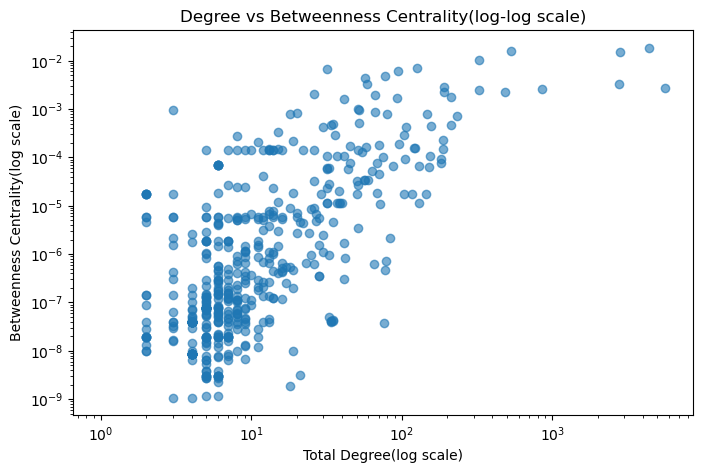

Spearman correlation between degree and betweenness centrality: 0.3744 (p-value: 0.0000)


In [42]:
plt.figure(figsize=(8,5))
plt.loglog(total_degrees, list(betweenness.values()), 'o', alpha=0.6)
plt.xlabel("Total Degree(log scale)")
plt.ylabel("Betweenness Centrality(log scale)")
plt.title("Degree vs Betweenness Centrality(log-log scale)")
plt.show()
#lets chekc the correlation
from scipy.stats import spearmanr
degree_values = np.array(list(total_degrees_dict.values()))
betweenness_values = np.array(list(betweenness.values()))
corr, p_value = spearmanr(degree_values, betweenness_values)
print(f"Spearman correlation between degree and betweenness centrality: {corr:.4f} (p-value: {p_value:.4f})")

We use log-log scale because both degree and betweeness follow a hevay-tailed distribution. 
The results show some mild correlation(0.37) between the two metrics, as nodes with higher degrees tend to have higher betweenness centrality.
This indicates that while hubs are often important in terms of shortest paths, many nodes with high degrees are not necessarily bridges.

#### In-degrees vs Out-degrees

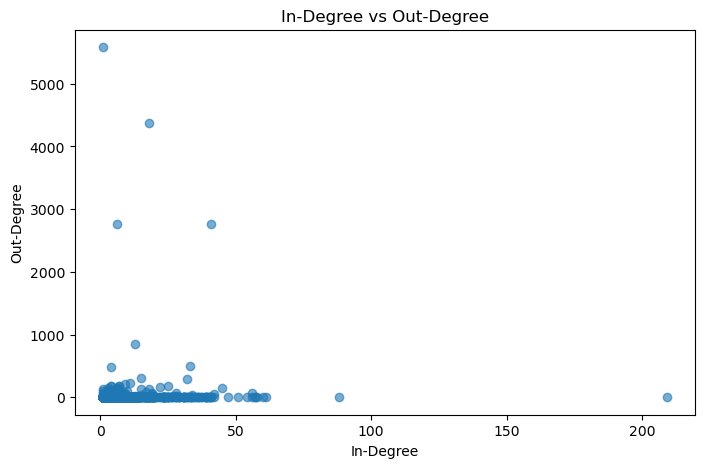

In [43]:
plt.figure(figsize=(8,5))
plt.scatter(in_degrees, out_degrees, alpha=0.6)
plt.xlabel("In-Degree")
plt.ylabel("Out-Degree")
plt.title("In-Degree vs Out-Degree")
plt.show()

There are some receivers and there are some hubs(receivers) and some directories(distributors).

#### Centrality Distribution Histograms

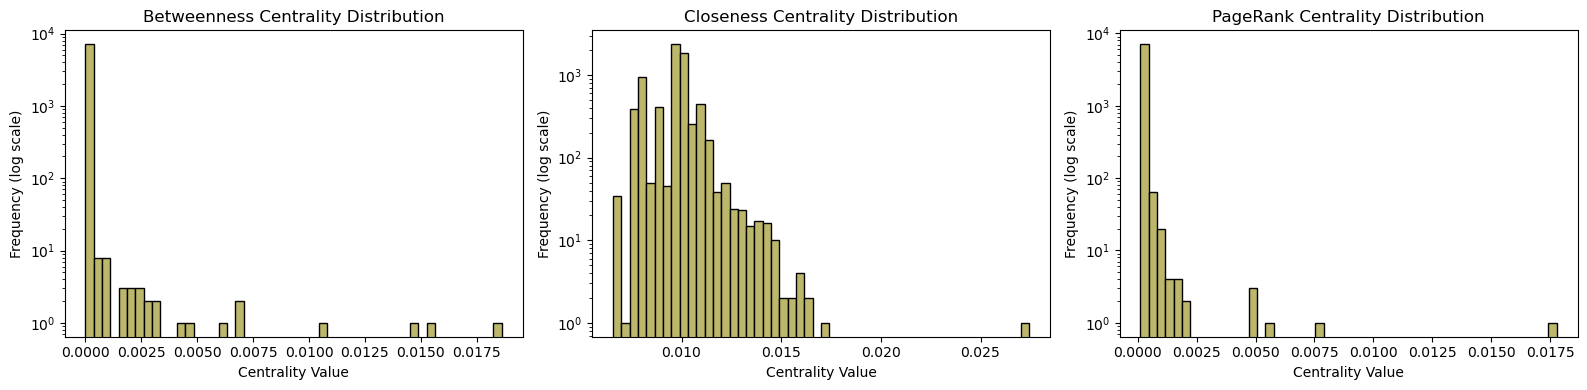

In [44]:
centrality_df = pd.DataFrame({
    "Betweenness": list(betweenness.values()),
    "Closeness": list(closeness.values()),
    "PageRank": list(pagerank.values())
}) # create a dataframe for easy handling

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for ax, col in zip(axes, centrality_df.columns):
    ax.hist(centrality_df[col], bins=50, color='darkkhaki', edgecolor='black', log=True)
    ax.set_title(f"{col} Centrality Distribution")
    ax.set_xlabel("Centrality Value")
    ax.set_ylabel("Frequency (log scale)")
plt.tight_layout()
plt.show()

- **Betweenness**: highly skewed, there are a little number of directories/brokers
- **Closeness**: not that highly skewed, log scale distribution almost looks normal, but it has at least an outlier, which is a super hub.
- **PageRank**: highly skewed again, some high values which are referenced by many sites. 

### Section 3 short Summary

We can again see that the network is sparse and skewed. Most nodes have low degrees and other centrality values and there are some major hubs. This again suggest the core-periphery strucutre is present and only a small numebr of nodes dominate connectivity and information flow.


# Section 4: Community discovery

### 4.1 Louvain method

Let's see what communities can we detect by the Louvain method. It maximizes modularity, a measure of how well a network can be decomposed into clusters. These communities are groups of domains that are more densely intra-connected then inter-connected.

In [45]:
communities = nx.algorithms.community.louvain_communities(G)

num_communities = len(communities)
print(f"Number of communities detected: {num_communities}")

Number of communities detected: 15


In [46]:
modularity_score = nx.community.modularity(G, communities)
print(f"Modularity (Q): {modularity_score:.4f}")

Modularity (Q): 0.3737


In [47]:
from collections import Counter
comm_sizes = [len(c) for c in communities]
size_counts = Counter(comm_sizes)
print("Top 10 largest community sizes:")
for i, size in enumerate(sorted(comm_sizes, reverse=True)[:10], start=1):
    print(f"Community {i}: {size} nodes")

Top 10 largest community sizes:
Community 1: 3429 nodes
Community 2: 812 nodes
Community 3: 767 nodes
Community 4: 557 nodes
Community 5: 533 nodes
Community 6: 369 nodes
Community 7: 347 nodes
Community 8: 251 nodes
Community 9: 58 nodes
Community 10: 37 nodes


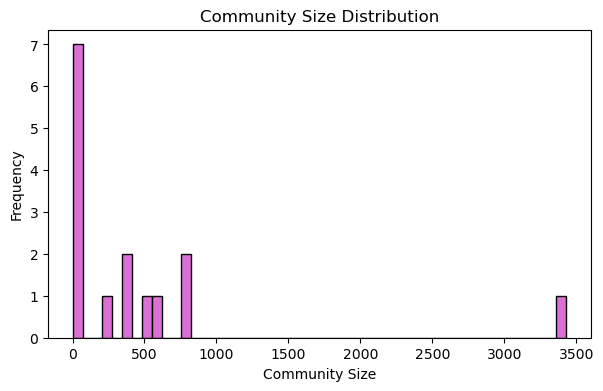

In [48]:
# Plot size distribution
plt.figure(figsize=(7,4))
plt.hist(comm_sizes, bins=50, color='orchid', edgecolor='black')
plt.title("Community Size Distribution")
plt.xlabel("Community Size")
plt.ylabel("Frequency")
plt.show()

We detected 15 communities, with Q=.37, which is a moderate seperation but they are still nut fully isolated. The smaller communities are most likely part of the periphery, while the biggest community's parts are part of the core.

### 4.2 Visualizations

Let's check out some plots so we can understand the communities better.

In [49]:
# Mapping nodes to their community
node_to_comm = {}
for idx, comm in enumerate(communities):
    for node in comm:
        node_to_comm[node] = idx


In [50]:
from itertools import chain

# Visualize the top 5 largest communities
top5_communities = sorted(communities, key=len, reverse=True)[:5]
top5_nodes = list(chain.from_iterable(top5_communities))
G_sub = G.subgraph(top5_nodes).copy()

# Assign community index for coloring
color_map = {}
for idx, comm in enumerate(top5_communities):
    for node in comm:
        color_map[node] = idx
colors = [color_map[n] for n in G_sub.nodes()]

In [51]:
# Plot
plt.figure(figsize=(10,8))
pos = nx.kamada_kawai_layout(G_sub)
nx.draw_networkx_nodes(G_sub, pos, node_size=40,node_color=colors, cmap='tab10')
nx.draw_networkx_edges(G_sub, pos, alpha=0.3)
plt.title("Top 5 Communities (Louvain)")
plt.axis('off')
plt.show()

KeyboardInterrupt: 

<Figure size 1000x800 with 0 Axes>

Ye, this doesn't really shows anything useful. Also it took 31 minutes to run..
<p> Let's try different methods to visualize it. We can try sampling 100 nodes from each of the top 5 communites and then plot it.

In [ ]:
import random
from itertools import chain

# Sample nodes per community
sample_nodes = []
for comm in top5_communities:
    sample_nodes.extend(random.sample(list(comm), min(200, len(comm))))

# Create subgraph
G_sample = G.subgraph(sample_nodes).copy()

# Remove isolated nodes (nodes with degree 0)
isolated = list(nx.isolates(G_sample))
G_sample.remove_nodes_from(isolated)
print(f"Removed {len(isolated)} isolated nodes from the sample")

# Rebuild colors after removal
sample_color_map = {n: color_map[n] for n in G_sample.nodes()}
colors = [sample_color_map[n] for n in G_sample.nodes()]


Removed 181 isolated nodes from the sample


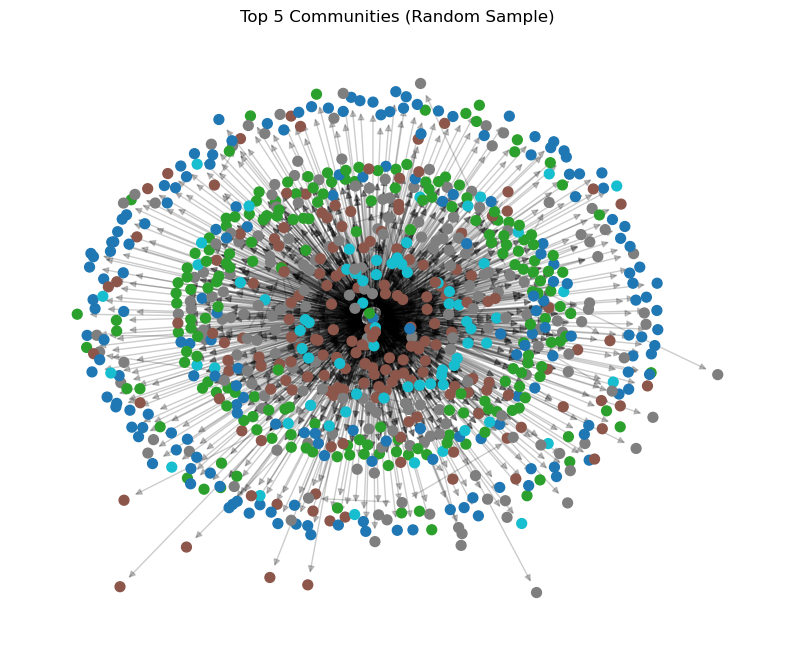

In [ ]:
import matplotlib.patches as mpatches

# Plot
plt.figure(figsize=(10,8))
pos = nx.spring_layout(G_sample)
nx.draw_networkx_nodes(G_sample, pos, node_color=colors, node_size=50, cmap='tab10')
nx.draw_networkx_edges(G_sample, pos, alpha=0.2)
plt.title("Top 5 Communities (Random Sample)")
plt.axis('off')


plt.show()


Not easy to notice much with this, maybe the core periphery structure again. The seperation of the communities is not apparent.

We can also to make every community into a single node, and sum the edges between communities. The node size can reflect the community size, edge thickness can reflect the inter-community connections.

In [ ]:
# Create meta-graph for all 15 communities
G_meta = nx.Graph()

# Add community nodes with size attribute
for idx, comm in enumerate(communities):
    G_meta.add_node(idx, size=len(comm))

# Add edges between communities
for i, comm_i in enumerate(communities):
    for j, comm_j in enumerate(communities):
        if i < j:
            weight = sum(1 for u in comm_i for v in comm_j if G.has_edge(u,v))
            if weight > 0:
                G_meta.add_edge(i, j, weight=weight)

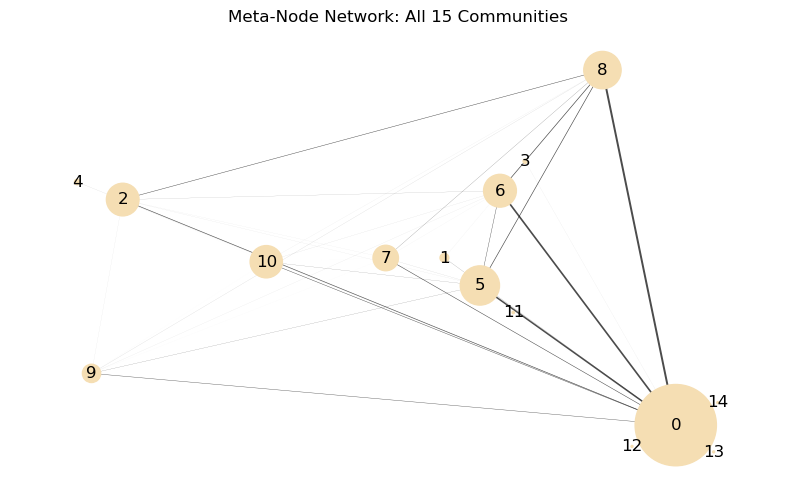

In [ ]:
# Plot
plt.figure(figsize=(10,6))
pos = nx.kamada_kawai_layout(G_meta)
sizes = [G_meta.nodes[n]['size'] for n in G_meta.nodes()]  # scale for visibility
weights = [G_meta.edges[e]['weight']/1000 for e in G_meta.edges()]  # scale for visibility

nx.draw_networkx_nodes(G_meta, pos, node_size=sizes, node_color='wheat')
nx.draw_networkx_edges(G_meta, pos, width=weights, alpha=0.7)
nx.draw_networkx_labels(G_meta, pos)
plt.title("Meta-Node Network: All 15 Communities")
plt.axis('off')
plt.show()

We can see that community 0 dominatesas core, the others are peripherial mostly.

### Section 4 Summary

The Louvain algorithm detected 15 communities, with a very large one dominating the network, reflecting a core-periphery structure. Visualizations of sampled nodes showed dubious results, while the meta-node graph shows the dominace of the biggest community.